In [49]:
import xgboost
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split


num_ftrs = ["v_0","v_1","v_2","v_3","v_4","v_5","v_6","v_7","v_8","v_9","v_10","v_11","v_12","v_13","v_14"]
max_ftrs =  [i for i in train_X if  i not in num_ftrs]
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
minmax_transformer = Pipeline(steps=[
('scaler', MinMaxScaler())])

preprocessor = ColumnTransformer(
            transformers=[
            ('num', numeric_transformer, num_ftrs),
            ('max', minmax_transformer, max_ftrs)
])
best_models = []
test_scores = np.zeros(5)
XGB = xgboost.XGBRegressor()
# # find the best parameter set
param_grid = {"max_depth": [2,3,4,5,9]}

param_grid = {"learning_rate": [0.1],
                "n_estimators": [200],
                "gamma":[0],
                "seed": [0],
                "missing": [np.nan],
                "max_depth": [2,3,4,5,9],
                "colsample_bytree": [0.9],
                "subsample": [0.8,0.75]}
pg = ParameterGrid(param_grid)
train_R2score = np.zeros(len(pg))
val_R2score = np.zeros(len(pg))
grid = []
#  create dataframes for train and val_scores to store the␣,→R2 score
# from the loop for each rand state
train_R2_df = pd.DataFrame()
val_R2_df = pd.DataFrame()
for i in range(5):
    print('randoms state '+ str(i))
    # let's split to train, CV, and test
    X_other, X_test, y_other, y_test = train_test_split(train_X, train_Y, test_size=0.2,random_state=42*i)
    X_train, X_CV, y_train, y_CV = train_test_split(X_other, y_other,test_size=0.25, random_state=42*i)
    # fit_transform the training set
    X_prep = preprocessor.fit_transform(X_train)
    # little hacky, but collect feature names
    feature_names = preprocessor.transformers_[0][-1] + preprocessor.transformers_[1][-1]
    df_train = pd.DataFrame(data=X_prep,columns=feature_names)
    # transform the CV
    X_CV_prep = preprocessor.transform(X_CV)

    # transform the test
    X_test_prep = preprocessor.transform(X_test)
    for k in range(len(pg)):
        params = pg[k]
        XGB.set_params(**params
                      )
        eval_set = [(X_CV_prep, y_CV)]
        XGB.fit(X=X_prep, y=y_train, early_stopping_rounds=10, eval_set=eval_set, verbose=False)
        grid.append(XGB)
        y_CV_pred = XGB.predict(X_CV_prep, ntree_limit=XGB.best_ntree_limit)
        y_train_pred = XGB.predict(X_prep,ntree_limit=XGB.best_ntree_limit)
        train_R2score[k] = r2_score(y_train,y_train_pred)
        val_R2score[k] = r2_score(y_CV,y_CV_pred)
    # collect and save the best model
    best_models.append(grid[np.argmax(val_R2score)])
    # calculate and save the test score
    y_test_pred = best_models[-1].predict(X_test_prep,ntree_limit=XGB.best_ntree_limit)
    test_scores[i] = r2_score(y_test,y_test_pred)
    print('the best max depth in the model parameters is:', pg[np.argmax(val_R2score)] , 'the matching test score is',test_scores[i])
    # get the val and train r2 scores into the dataframes that created before, for comparison
    train_R2_df[42*i] = train_R2score
    val_R2_df[42*i] = val_R2score

randoms state 0
the best max depth in the model parameters is: {'subsample': 0.75, 'seed': 0, 'n_estimators': 200, 'missing': nan, 'max_depth': 9, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.9} the matching test score is 0.9653566161830031
randoms state 1
the best max depth in the model parameters is: {'subsample': 0.8, 'seed': 0, 'n_estimators': 200, 'missing': nan, 'max_depth': 9, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.9} the matching test score is 0.9626788956266471
randoms state 2
the best max depth in the model parameters is: {'subsample': 0.8, 'seed': 0, 'n_estimators': 200, 'missing': nan, 'max_depth': 9, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.9} the matching test score is 0.9635968513122004
randoms state 3
the best max depth in the model parameters is: {'subsample': 0.75, 'seed': 0, 'n_estimators': 200, 'missing': nan, 'max_depth': 9, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.9} the matching test score is 0.96498383626

In [51]:
r2_score_xg = [0.9693566161830031,0.9676788956266471,0.9685968513122004,0.969983836267007,0.9677852076231475]
r2score_mean = np.mean(r2_score_xg)
r2score_mean

0.9686802814024009

In [59]:
r2_score_std = ([0.9693566161830031,0.9676788956266471,0.9685968513122004,0.969983836267007,0.9677852076231475])
np.std(r2_score_std)

0.0008907946051285189

In [52]:
# from result above the best parameter is below
import xgboost as xgb
xgr = xgb.XGBRegressor(n_estimators=200, 
    learning_rate=0.1, 
    gamma=0, 
    subsample=0.8,
    colsample_bytree=0.9,
    max_depth=9) #,objective ='reg:squarederror'
xgr.fit(train_X,train_Y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.9, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=9,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=200, n_jobs=12, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [53]:
pre = xgr.predict(test_X)
pre1 = xgr.predict(train_X)
sub_new = pd.concat([df1[df1['SaleID'].isnull()],pd.DataFrame(np.expm1(pre))],axis =1).rename({0:"price"},axis=1)
sub_new[['SaleID',"price"]].to_csv(r'../results/submit.csv')

In [54]:
print('R2 score now:', r2_score(pre1,train_Y))

R2 score now: 0.9870766272099433


In [55]:
import shap
explainer = shap.TreeExplainer(xgr)
shap_values = explainer.shap_values(train_X)

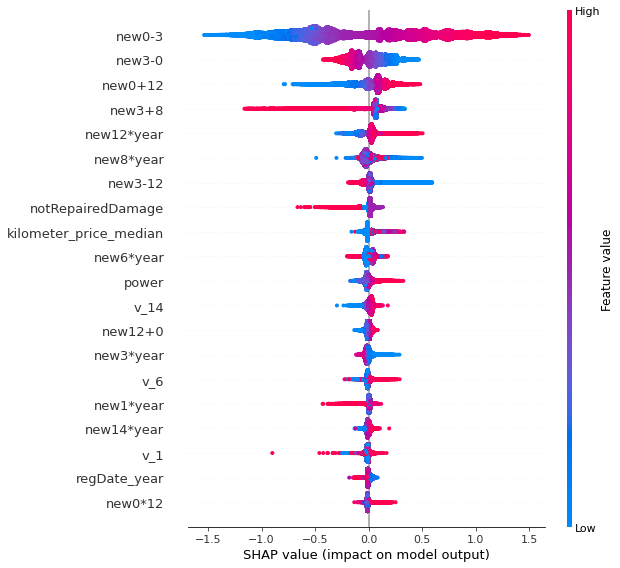

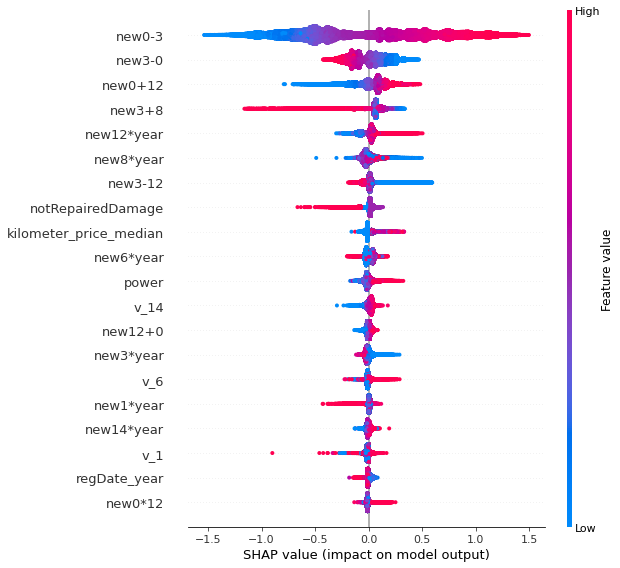

In [56]:
shap.summary_plot(shap_values, train_X)
fig = shap.summary_plot(shap_values, train_X, show=False)
plt.savefig(r'../results/shap1.png',dpi=300, format="PNG")

In [57]:
global_importance = pd.Series(xgr.feature_importances_, index = train_X.columns.tolist())
pd.set_option('display.max_rows', 1000)
global_importance.sort_values(ascending=True)


kilometer_power_count     0.000000
new12-12                  0.000000
new8-8                    0.000000
new3-3                    0.000000
new0-0                    0.000000
new0+0                    0.000000
kilometer_power_sum       0.000000
kilometer_power_min       0.000000
fuelType_price_sum        0.000000
creatDate_year            0.000000
model                     0.000033
bodyType                  0.000035
fuelType                  0.000054
v_0                       0.000057
fuelType_price_min        0.000059
fuelType_price_max        0.000078
new8+0                    0.000078
brand                     0.000082
bodyType_price_mean       0.000083
new3+0                    0.000084
fuelType_price_std        0.000090
regDate_day               0.000090
gearbox                   0.000092
regDate_month             0.000094
new0*0                    0.000098
creatDate_day             0.000098
kilometer_power_median    0.000102
v_4                       0.000103
kilometer_price_std 

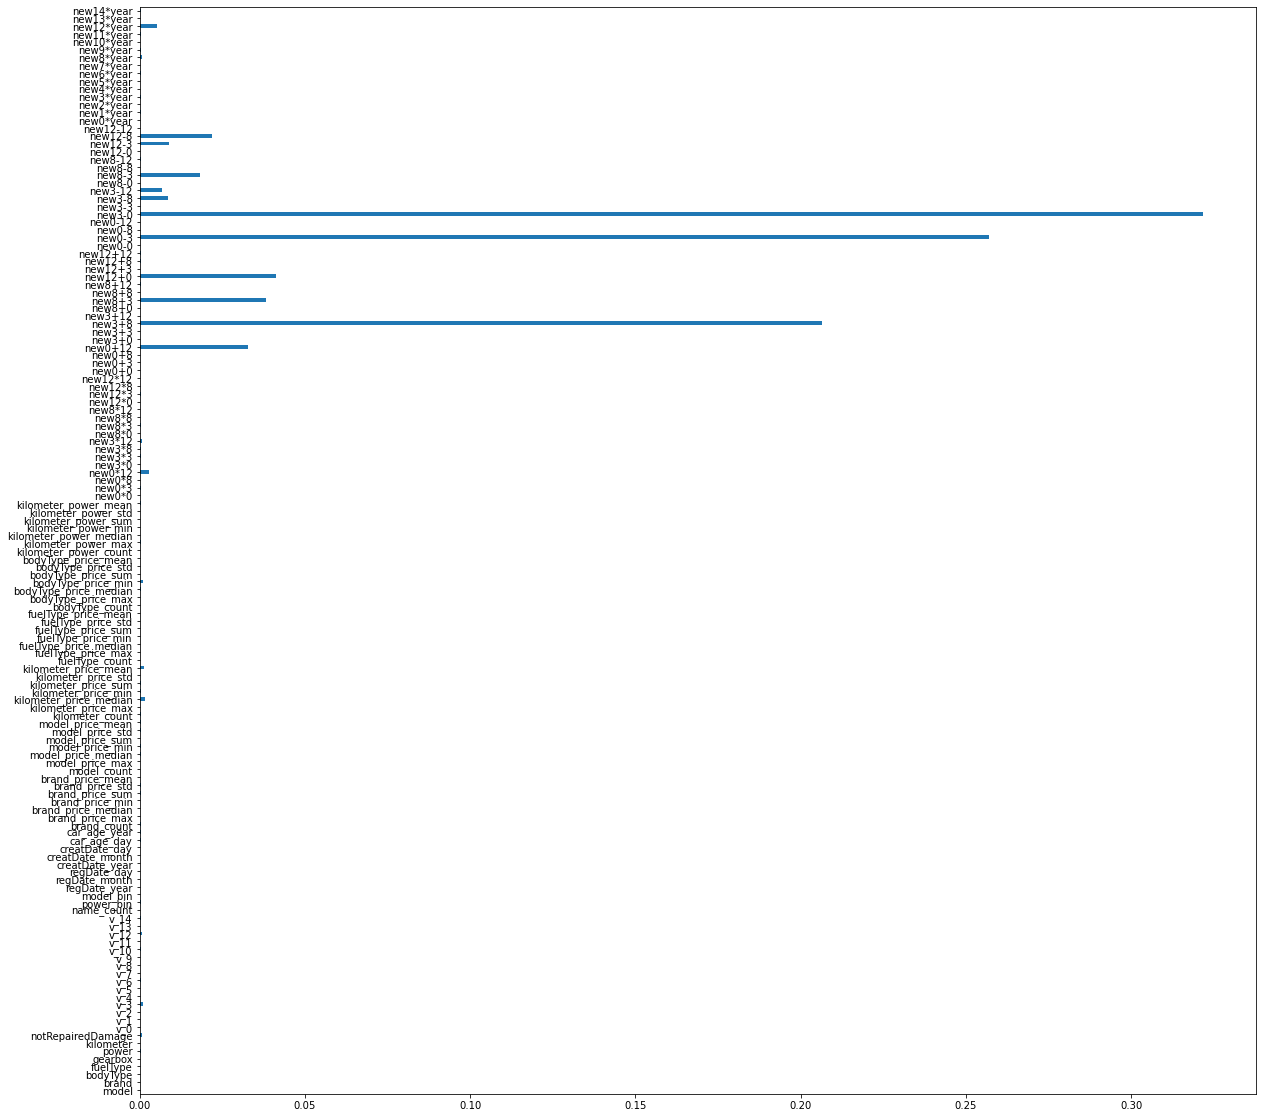

In [58]:
fig = plt.figure(figsize=(20,20))

fig = global_importance.plot(kind = 'barh')
plt.savefig(r'../results/xgbr feature importance.png',dpi=300, format="PNG")